## Modelo de classificação para diagnosticar tipos de Arritmia baseado em dados de eletrocardiograma (ECG)

### Importação das bibliotecas e descompactação do dataset

Necessário fazer o download do dataset (zipado) e colocar na pasta `src/dataset` para rodar os códigos seguintes. Este dataset é o mesmo que foi encontrado na fase 1 pelo nosso grupo.

[ECG Arrhythmia Classification Dataset](https://fiapcom-my.sharepoint.com/:u:/g/personal/rm561051_fiap_com_br/EUL5r0U5bAhOnn2__Zy3ihgBHXxoLiQowgvPyvLmaE21LA?e=FyJnjr)

In [1]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
ZIP_PATH = '../dataset/ECG_Arrhythmia_Classification_Dataset.zip'
EXTRACT_PATH = '../dataset'

In [3]:
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
  zip_ref.extractall(EXTRACT_PATH)

print('Dataset descompactado em: ', EXTRACT_PATH)

Dataset descompactado em:  ../dataset


### Análise exploratória nos dados

In [4]:
df_1 = pd.read_csv('../dataset/INCART 2-lead Arrhythmia Database.csv')
df_2 = pd.read_csv('../dataset/MIT-BIH Arrhythmia Database.csv')
df_3 = pd.read_csv('../dataset/MIT-BIH Supraventricular Arrhythmia Database.csv')
df_4 = pd.read_csv('../dataset/Sudden Cardiac Death Holter Database.csv')

df = pd.concat([df_1, df_2, df_3, df_4], ignore_index=True)
df.head()

/tmp/ipykernel_25198/3065877735.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_4 = pd.read_csv('../dataset/Sudden Cardiac Death Holter Database.csv')


,record,type,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,...,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
0,I01,N,163.0,165.0,0.069610,-0.083281,0.614133,-0.392761,0.047159,15.0,...,-0.023370,14.0,3.0,23.0,6.0,-0.023370,-0.011650,0.082608,0.101373,-0.183387
1,I01,N,165.0,166.0,-0.097030,0.597254,-0.078704,-0.078704,-0.137781,3.0,...,0.081637,15.0,5.0,27.0,7.0,0.081637,0.102992,0.191225,0.217544,-0.068248
2,I01,N,166.0,102.0,0.109399,0.680528,-0.010649,-0.010649,-0.720620,6.0,...,-0.148539,33.0,13.0,52.0,6.0,-0.148539,-0.060620,0.081080,0.204400,0.335172
3,I01,VEB,102.0,231.0,0.176376,0.256431,-0.101098,-0.707525,-0.101098,4.0,...,0.046898,21.0,9.0,34.0,4.0,0.046898,0.083728,0.279512,0.526785,0.450969
4,I01,N,231.0,165.0,0.585577,0.607461,-0.083499,-0.083499,-0.167858,3.0,...,-0.112552,32.0,5.0,43.0,6.0,-0.112552,0.012989,0.091491,0.134004,0.265232


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 963654 entries, 0 to 963653
Data columns (total 34 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   record          887437 non-null  object 
 1   type            887437 non-null  object 
 2   0_pre-RR        887437 non-null  float64
 3   0_post-RR       887437 non-null  float64
 4   0_pPeak         887437 non-null  float64
 5   0_tPeak         887437 non-null  float64
 6   0_rPeak         887437 non-null  float64
 7   0_sPeak         887437 non-null  float64
 8   0_qPeak         887437 non-null  float64
 9   0_qrs_interval  887437 non-null  float64
 10  0_pq_interval   887437 non-null  float64
 11  0_qt_interval   887437 non-null  float64
 12  0_st_interval   887437 non-null  float64
 13  0_qrs_morph0    887437 non-null  float64
 14  0_qrs_morph1    887437 non-null  float64
 15  0_qrs_morph2    887437 non-null  float64
 16  0_qrs_morph3    887437 non-null  float64
 17  0_qrs_morp

Remove todas as linhas com alguma coluna nula.

In [6]:
df = df.dropna()
len(df)

712822

É possível observar um grande desbalanceamento no dataset.

In [7]:
df['type'].value_counts()

type
N       644711
VEB      48212
SVEB     18501
F         1255
Q          143
Name: count, dtype: int64

One Hot Encoding da variável categórica para exibir na matriz de confusão.

In [8]:
df_encoded = pd.get_dummies(df, columns=['type'], prefix='type')

In [9]:
corr = df_encoded.select_dtypes(include=['int64', 'float64', 'bool']).corr()

corr_y = corr[['type_N', 'type_Q', 'type_SVEB', 'type_VEB', 'type_F']]

Matriz de correlação com a variável dependente (rótulo) *type*.

Text(0.5, 1.0, 'Matriz de Correlação')

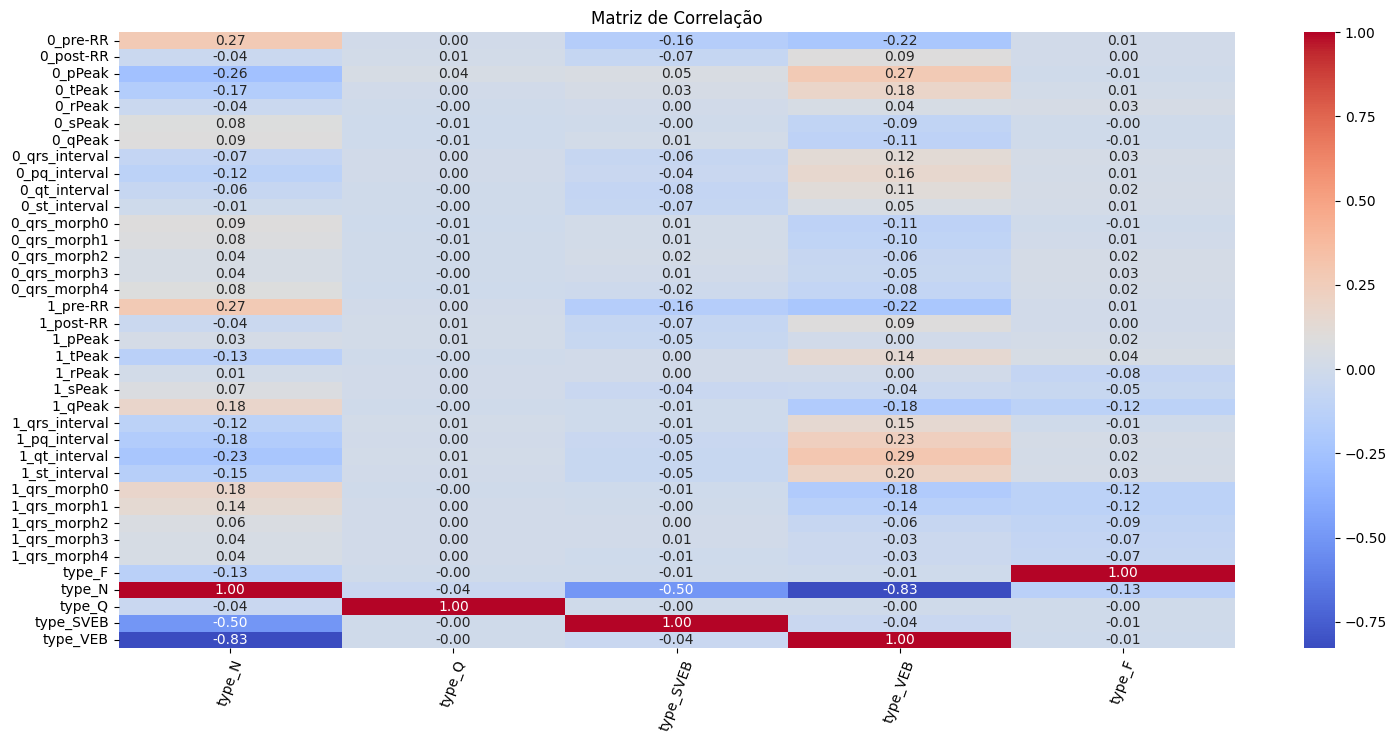

In [10]:
plt.figure(figsize=(18,8))
sns.heatmap(data=corr_y, annot=True, cmap='coolwarm', fmt='.2f')
plt.xticks(rotation=70)
plt.title("Matriz de Correlação")

### Criação do pipeline de pré-processamento dos dados

In [11]:
numeric_features = df.columns.drop(['type', 'record'])
numeric_features

Index(['0_pre-RR', '0_post-RR', '0_pPeak', '0_tPeak', '0_rPeak', '0_sPeak',
       '0_qPeak', '0_qrs_interval', '0_pq_interval', '0_qt_interval',
       '0_st_interval', '0_qrs_morph0', '0_qrs_morph1', '0_qrs_morph2',
       '0_qrs_morph3', '0_qrs_morph4', '1_pre-RR', '1_post-RR', '1_pPeak',
       '1_tPeak', '1_rPeak', '1_sPeak', '1_qPeak', '1_qrs_interval',
       '1_pq_interval', '1_qt_interval', '1_st_interval', '1_qrs_morph0',
       '1_qrs_morph1', '1_qrs_morph2', '1_qrs_morph3', '1_qrs_morph4'],
      dtype='object')

In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', MinMaxScaler(), numeric_features)
    ]
)

### Diminuindo as ocorrências da classe majoritária

In [13]:
majority = df[df['type'] == 'N']
minority = df[df['type'] != 'N'] # Para classe minoritária, apenas pegamos todos os diferentes da classe majoritária

# A função sample sorteia aleatoriamente linhas de um dataframe, no caso, sorteia X linhas baseado no número enviado pelo parâmetro da função
majority_undersampling = majority.sample(50000, random_state=849)

df_balanced = pd.concat([majority_undersampling, minority])

In [14]:
df_balanced['type'].value_counts()

type
N       50000
VEB     48212
SVEB    18501
F        1255
Q         143
Name: count, dtype: int64

### Separando os dados em treino, teste e validação

Para treino e validação será usado os conjuntos *X_train* e *y_train*, para os de teste serão usados os conjuntos *X_test* e *y_test*.

In [15]:
SEED = 357

X = df_balanced[numeric_features]
y = df_balanced['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=SEED)

### Testando modelos

In [16]:
def view_cross_validate_scores(results):
    test_mean = results['test_score'].mean()
    train_mean = results['train_score'].mean()

    print(f'Acurácia média treino: {train_mean*100:.2f}%')
    print(f'Acurácia média teste: {test_mean*100:.2f}%')

In [17]:
labels = np.unique(df['type'])

def scores(model, test_x, test_y):
    # Acurácia
    model_acc = model.score(test_x, test_y)
    print(f'Acurácia do modelo: {model_acc*100:.2f}%')
    
    predicts = model.predict(test_x)

    # Matriz de confusão
    cm = confusion_matrix(test_y, predicts)

    plt.figure(figsize=(12,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Valores Preditos')
    plt.ylabel('Valores Reais')
    plt.title('Matriz de Confusão')
    plt.show()
    
    # Classification report
    print(classification_report(predicts, test_y, zero_division=False))

#### Random Forest

In [18]:
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('estimator', RandomForestClassifier(random_state=SEED))
])

**Validação cruzada com os dados de treino**

In [19]:
results = cross_validate(pipeline_rf, X_train, y_train, cv=StratifiedShuffleSplit(n_splits=10, random_state=SEED), return_train_score=True)
view_cross_validate_scores(results)

Acurácia média treino: 100.00%
Acurácia média teste: 96.44%


**Treinando e testando o modelo**

In [20]:
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  Index(['0_pre-RR', '0_post-RR', '0_pPeak', '0_tPeak', '0_rPeak', '0_sPeak',
       '0_qPeak', '0_qrs_interval', '0_pq_interval', '0_qt_interval',
       '0_st_interval', '0_qrs_morph0', '0_qrs_morph1', '0_qrs_morph2',
       '0_qrs_morph3', '0_qrs_morph4', '1_pre-RR', '1_post-RR', '1_pPeak',
       '1_tPeak', '1_rPeak', '1_sPeak', '1_qPeak', '1_qrs_interval',
       '1_pq_interval', '1_qt_interval', '1_st_interval', '1_qrs_morph0',
       '1_qrs_morph1', '1_qrs_morph2', '1_qrs_morph3', '1_qrs_morph4'],
      dtype='object'))])),
                ('estimator', RandomForestClassifier(random_state=357))])

Acurácia do modelo: 96.43%


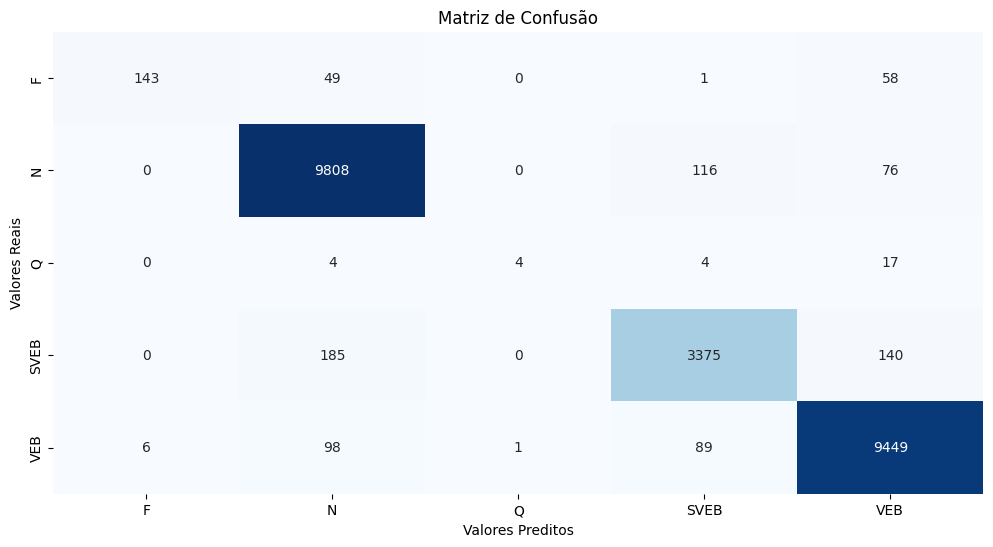

              precision    recall  f1-score   support

           F       0.57      0.96      0.71       149
           N       0.98      0.97      0.97     10144
           Q       0.14      0.80      0.24         5
        SVEB       0.91      0.94      0.93      3585
         VEB       0.98      0.97      0.97      9740

    accuracy                           0.96     23623
   macro avg       0.72      0.93      0.77     23623
weighted avg       0.97      0.96      0.97     23623



In [22]:
scores(pipeline_rf, X_test, y_test)